<a href="https://colab.research.google.com/github/SolKidonakis/AA2TP2/blob/main/Ejercicio%201/TP2AA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TRABAJO PRACTICO N°2: APRENDIZAJE AUTOMATICO 2**

ALUMNA: SOL KIDONAKIS


**LIBRERIAS**

In [ ]:
!pip install tensorflow tensorflow-datasets matplotlib librosa


In [ ]:
!pip install pydub


In [ ]:
!apt-get update && apt-get install -y ffmpeg


In [ ]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import tensorflow_datasets as tfds
from google.colab import drive
import librosa
import librosa.display
from tqdm import tqdm


**CARGA DEL DATASET**

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# Configure GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [ ]:

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


dataset_path = '/content/drive/My Drive/AA2/dataset_reducido'
print(f"Archivos en la carpeta: {os.listdir(dataset_path)}")


Archivos en la carpeta: ['español', 'frances', 'japones', 'ingles']


In [ ]:
languages = os.listdir(dataset_path)
print(f"Idiomas disponibles: {languages}")



Idiomas disponibles: ['español', 'frances', 'japones', 'ingles']


**ANALISIS EXPLORATORIO**

Cantidad de muestras por idioma:
español: 200
frances: 200
japones: 200
ingles: 200


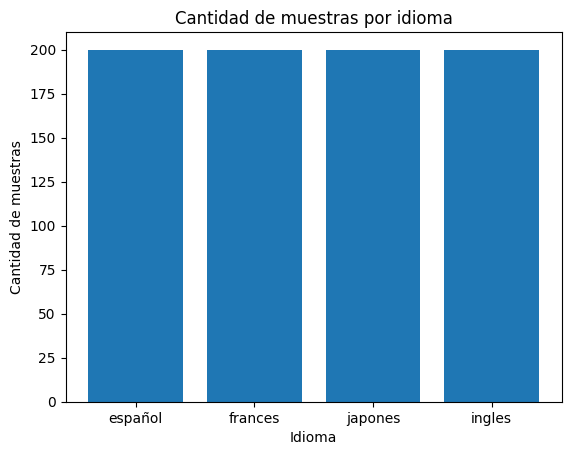

In [ ]:
samples_per_language = {lang: len(os.listdir(os.path.join(dataset_path, lang))) for lang in languages}
print("Cantidad de muestras por idioma:")
for lang, count in samples_per_language.items():
    print(f"{lang}: {count}")

# Gráfico
plt.bar(samples_per_language.keys(), samples_per_language.values())
plt.title('Cantidad de muestras por idioma')
plt.xlabel('Idioma')
plt.ylabel('Cantidad de muestras')
plt.show()


Al usar un dataset reducido,contamos con 200 muestras por idioma

Procesando ingles: 100%|██████████| 200/200 [00:07<00:00, 26.42it/s] 


Duración promedio de clips por idioma:
español: 10.00 segundos
frances: 10.00 segundos
japones: 10.00 segundos
ingles: 10.00 segundos


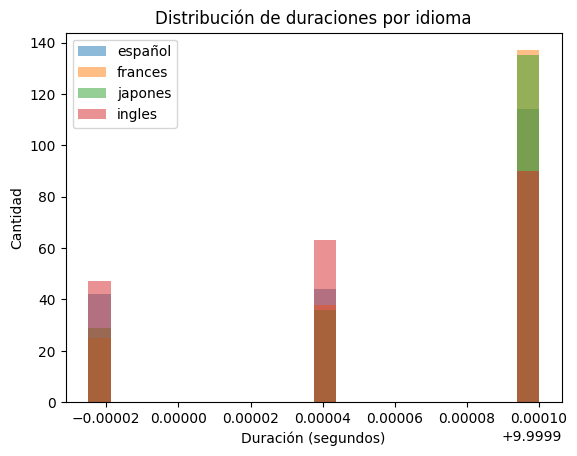

In [ ]:
def get_audio_durations(dataset_path):
    durations = {}
    for lang in languages:
        lang_path = os.path.join(dataset_path, lang)
        durations[lang] = []
        for file in tqdm(os.listdir(lang_path), desc=f"Procesando {lang}"):
            file_path = os.path.join(lang_path, file)
            y, sr = librosa.load(file_path, sr=None)
            durations[lang].append(librosa.get_duration(y=y, sr=sr))
    return durations

durations = get_audio_durations(dataset_path)

# Duración promedio por idioma
avg_durations = {lang: np.mean(durations[lang]) for lang in durations}
print("Duración promedio de clips por idioma:")
for lang, avg in avg_durations.items():
    print(f"{lang}: {avg:.2f} segundos")

# Graficar distribuciones
for lang in durations:
    plt.hist(durations[lang], bins=20, alpha=0.5, label=lang)
plt.legend()
plt.title('Distribución de duraciones por idioma')
plt.xlabel('Duración (segundos)')
plt.ylabel('Cantidad')
plt.show()


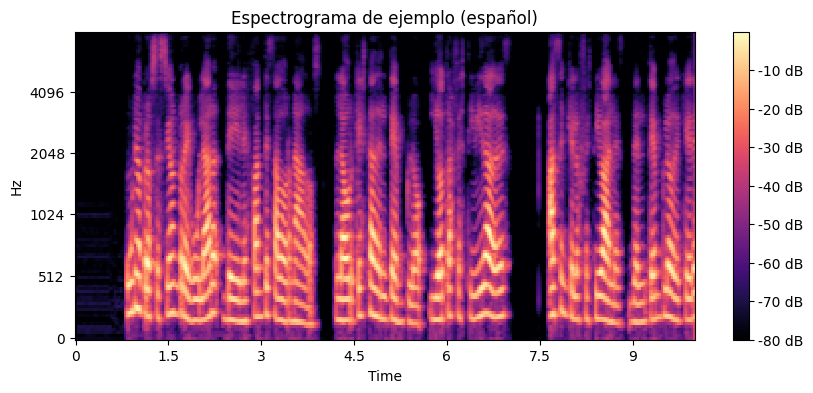

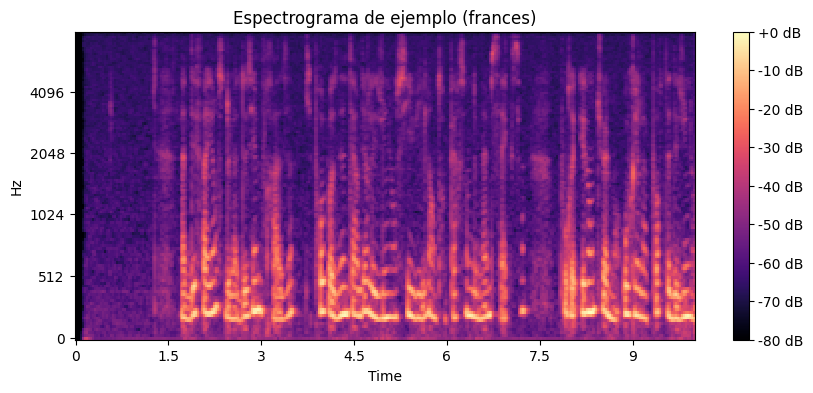

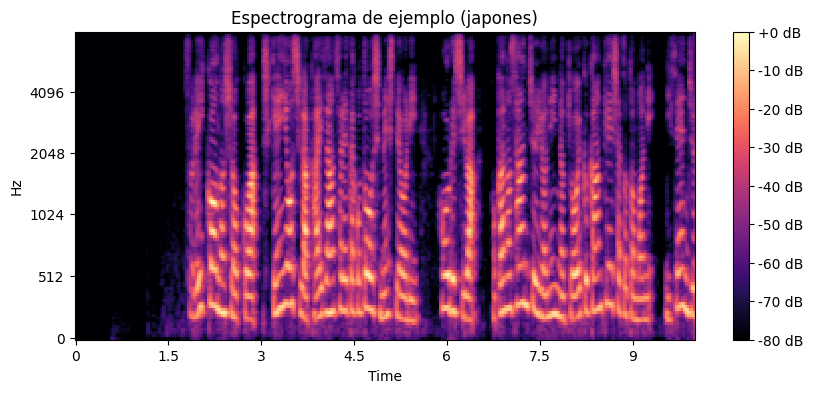

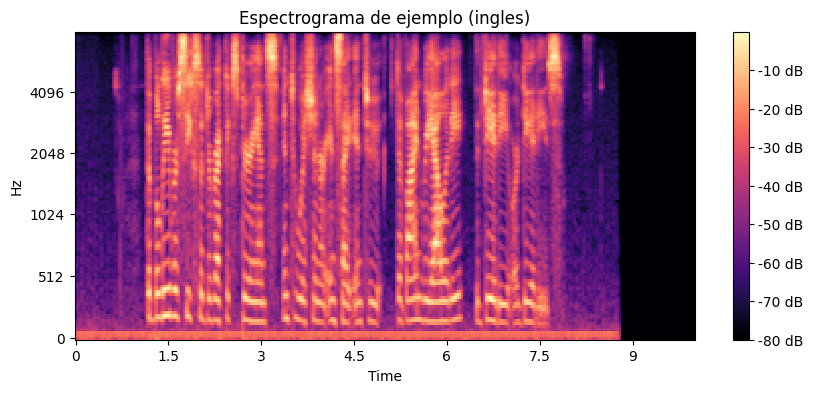

In [ ]:


# Función para generar y visualizar un espectrograma
def plot_spectrogram(file_path, title):
    y, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Mostrar un espectrograma de ejemplo por idioma
for lang in languages:
    example_file = os.path.join(dataset_path, lang, os.listdir(os.path.join(dataset_path, lang))[0])
    plot_spectrogram(example_file, title=f"Espectrograma de ejemplo ({lang})")


**SPLIT DATA**

In [ ]:
train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=dataset_path,
    batch_size=64,
    validation_split=0.2,
    output_sequence_length=16000,
    seed=seed,
    subset='training'
)

val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=dataset_path,
    batch_size=64,
    validation_split=0.2,
    output_sequence_length=16000,
    seed=seed,
    subset='validation'
)

# Obtener nombres de las clases (idiomas)
label_names = np.array(train_ds.class_names)
print("Clases (Idiomas):", label_names)


Found 800 files belonging to 4 classes.
Using 640 files for training.
Found 800 files belonging to 4 classes.
Using 160 files for validation.
Clases (Idiomas): ['español' 'frances' 'ingles' 'japones']


**PREPROCESAMIENTO DE LOS ARCHIVOS DE AUDIO**

In [ ]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)  # Quitar eje extra
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# Inspeccionar datos
for example_audio, example_labels in train_ds.take(1):
    print("Forma de audio:", example_audio.shape)
    print("Forma de etiquetas:", example_labels.shape)



Forma de audio: (64, 16000)
Forma de etiquetas: (64,)


**ESPECTOGRAMAS**

---



In [ ]:

# Crear espectrogramas
def get_spectrogram(audio, label):
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]  # Añadir canal para CNN
    return spectrogram, label

train_spectrogram_ds = train_ds.map(get_spectrogram, tf.data.AUTOTUNE)
val_spectrogram_ds = val_ds.map(get_spectrogram, tf.data.AUTOTUNE)


Idioma: español
Forma de onda: (160000,)
Reproducción de Audio:


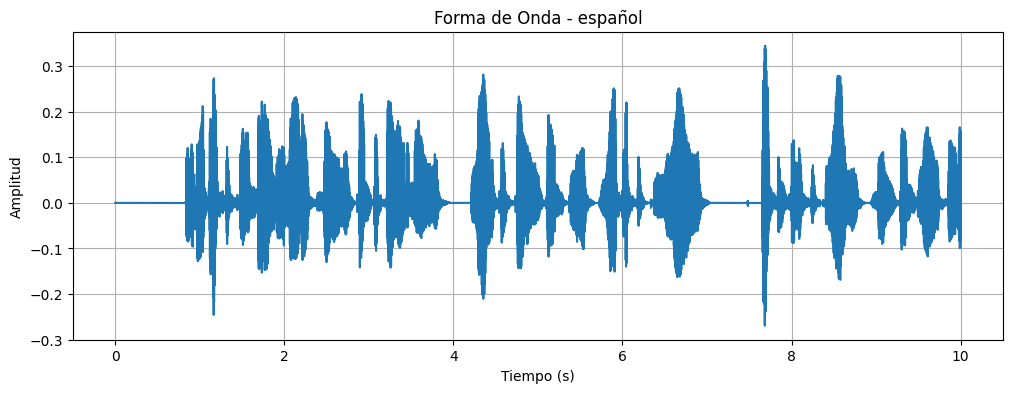

Idioma: frances
Forma de onda: (160000,)
Reproducción de Audio:


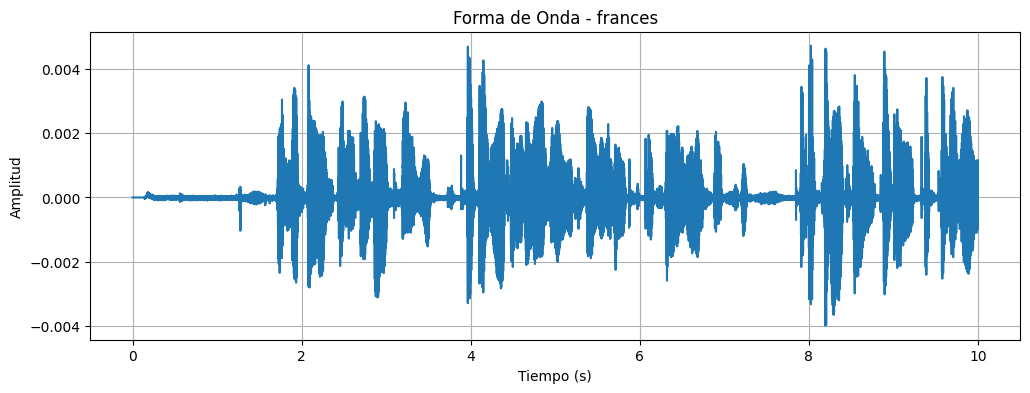

Idioma: japones
Forma de onda: (160000,)
Reproducción de Audio:


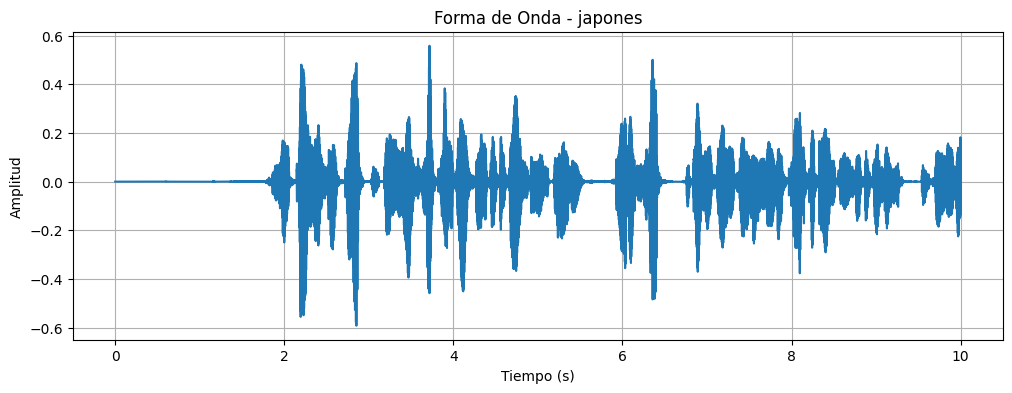

Idioma: ingles
Forma de onda: (159999,)
Reproducción de Audio:


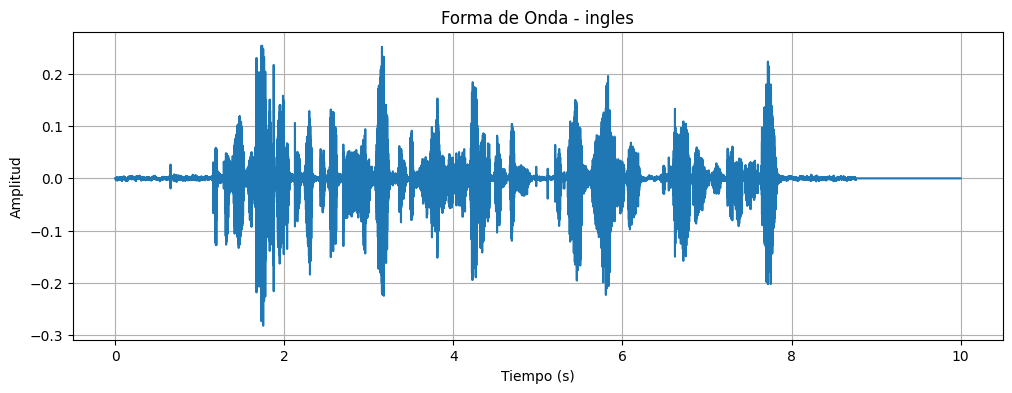

In [ ]:
# Importar librerías necesarias para reproducir audio
from IPython.display import Audio, display

# Función para cargar y reproducir audio, y mostrar su forma de onda
def display_audio_and_waveform(file_path, label):
    # Cargar el archivo de audio
    y, sr = librosa.load(file_path, sr=16000)  # Asegurar una tasa de muestreo consistente

    # Mostrar información del archivo
    print(f"Idioma: {label}")
    print(f"Forma de onda: {y.shape}")
    print("Reproducción de Audio:")
    display(Audio(y, rate=sr))  # Reproducir el archivo de audio

    # Graficar forma de onda
    plt.figure(figsize=(12, 4))
    plt.plot(np.linspace(0, len(y)/sr, len(y)), y)
    plt.title(f"Forma de Onda - {label}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

# Reproducir una muestra de audio y mostrar su forma de onda para cada idioma
for lang in languages:
    lang_path = os.path.join(dataset_path, lang)
    example_file = os.path.join(lang_path, os.listdir(lang_path)[0])  # Tomar un archivo de ejemplo
    display_audio_and_waveform(example_file, label=lang)


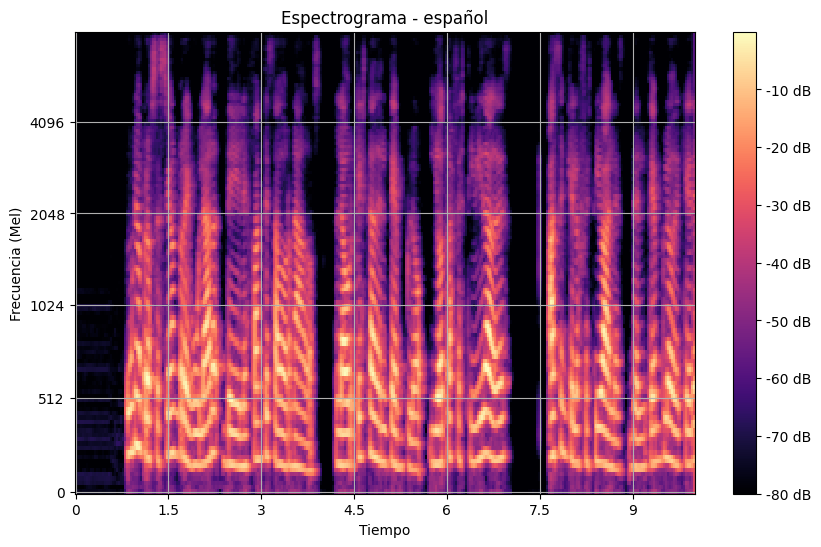

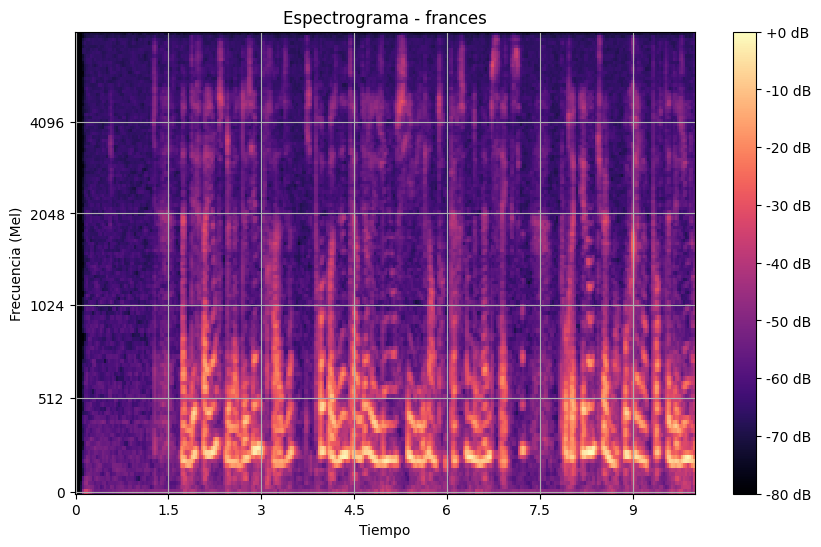

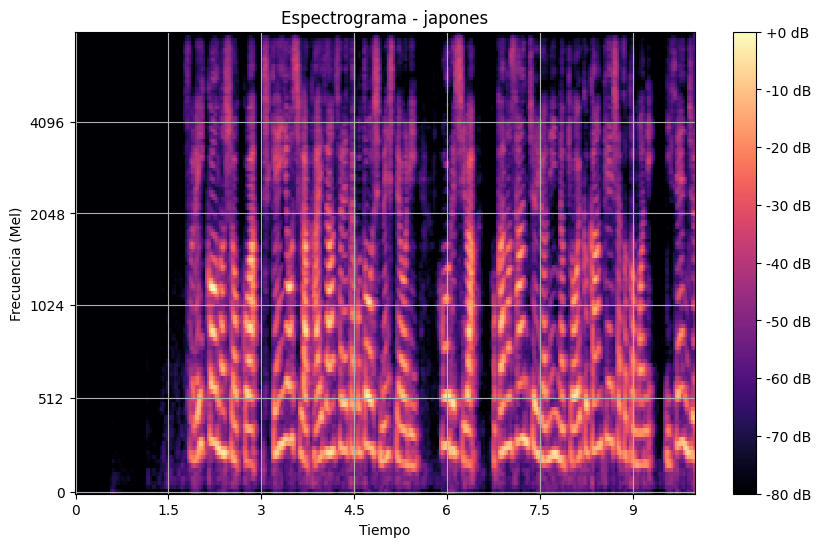

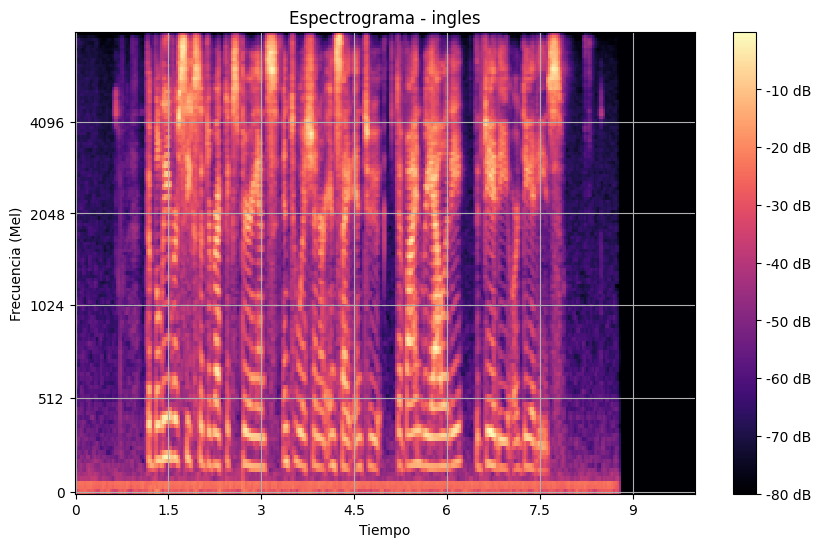

In [ ]:
# Función para graficar un espectrograma
def display_spectrogram(file_path, label):
    # Cargar el archivo de audio
    y, sr = librosa.load(file_path, sr=16000)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Graficar espectrograma
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Espectrograma - {label}")
    plt.xlabel("Tiempo")
    plt.ylabel("Frecuencia (Mel)")
    plt.grid()
    plt.show()

# Graficar espectrograma para cada idioma
for lang in languages:
    lang_path = os.path.join(dataset_path, lang)
    example_file = os.path.join(lang_path, os.listdir(lang_path)[0])  # Tomar un archivo de ejemplo
    display_spectrogram(example_file, label=lang)


In [ ]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: get_spectrogram(audio, label),  # Correcto
        num_parallel_calls=tf.data.AUTOTUNE
    )


train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

# Optimizar datasets
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


**ENTRENAMIENTO DE LOS MODELOS**

In [ ]:
# Definir la forma de entrada y el número de etiquetas
input_shape = next(iter(train_spectrogram_ds))[0].shape[1:]  # Forma de los espectrogramas
num_labels = len(label_names)  # Número de clases

print('Input shape:', input_shape)

# Instanciar y adaptar la capa de normalización
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


Input shape: (124, 129, 1)


**MODELO CONVOLUCIONAL**

In [ ]:
def build_cnn_model(input_shape, num_labels):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(32, 32),  # Redimensionar
        norm_layer,               # Normalización
        layers.Conv2D(32, 3, activation='relu'),  # Capas convolucionales
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),                   # Pooling
        layers.Dropout(0.25),                    # Regularización
        layers.Flatten(),                        # Aplanar
        layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),    # Capa densa
        layers.Dropout(0.5),
        layers.Dense(num_labels),                # Capa de salida
    ])
    return model


In [ ]:
# Versión para CNN: Añadir dimensión de canal
def add_channel_dimension(spec, label):
    return tf.expand_dims(spec, axis=-1), label

train_spectrogram_cnn_ds = train_spectrogram_ds.map(add_channel_dimension, tf.data.AUTOTUNE)
val_spectrogram_cnn_ds = val_spectrogram_ds.map(add_channel_dimension, tf.data.AUTOTUNE)

In [ ]:
cnn_model = build_cnn_model(input_shape, num_labels)

# Compilar el modelo CNN
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Entrenar el modelo CNN
cnn_history = cnn_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)],
)

# Evaluar el modelo CNN
cnn_eval = cnn_model.evaluate(val_spectrogram_ds)
print(f"CNN Validation Loss: {cnn_eval[0]}, CNN Validation Accuracy: {cnn_eval[1]}")


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.2908 - loss: 3.3857 - val_accuracy: 0.3875 - val_loss: 2.0731
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.3673 - loss: 1.9059 - val_accuracy: 0.4313 - val_loss: 1.5537
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.4369 - loss: 1.5216 - val_accuracy: 0.4563 - val_loss: 1.4188
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.4168 - loss: 1.4383 - val_accuracy: 0.4938 - val_loss: 1.3464
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5158 - loss: 1.3304 - val_accuracy: 0.4750 - val_loss: 1.3008
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4911 - loss: 1.3070 - val_accuracy: 0.5500 - val_loss: 1.2644
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - accuracy: 0.5020 - loss: 1.2853 - val_accuracy: 0.5312 - val_loss: 1.2518
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.5398 - loss: 1.2580 - val_accuracy: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Ejemplo 1:
Etiqueta real: japones
Predicción: japones


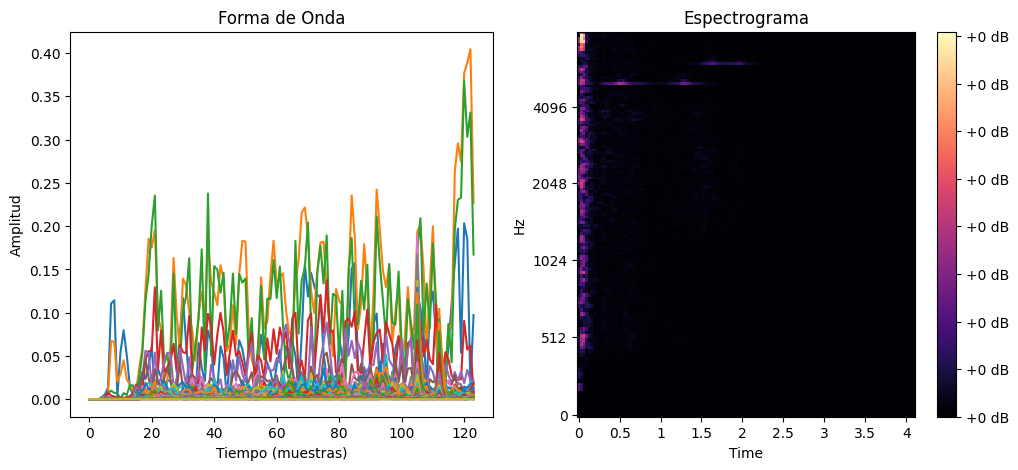

Ejemplo 2:
Etiqueta real: ingles
Predicción: ingles


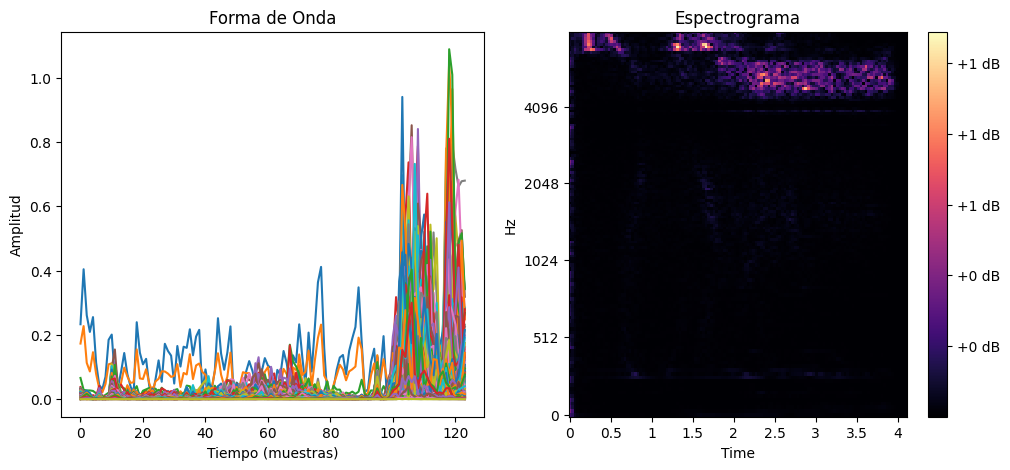

Ejemplo 3:
Etiqueta real: español
Predicción: frances


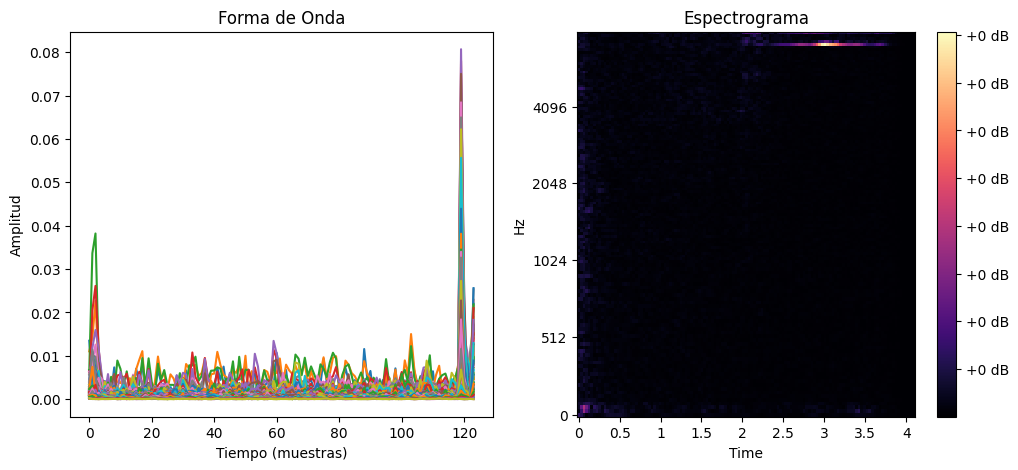

Ejemplo 4:
Etiqueta real: frances
Predicción: frances


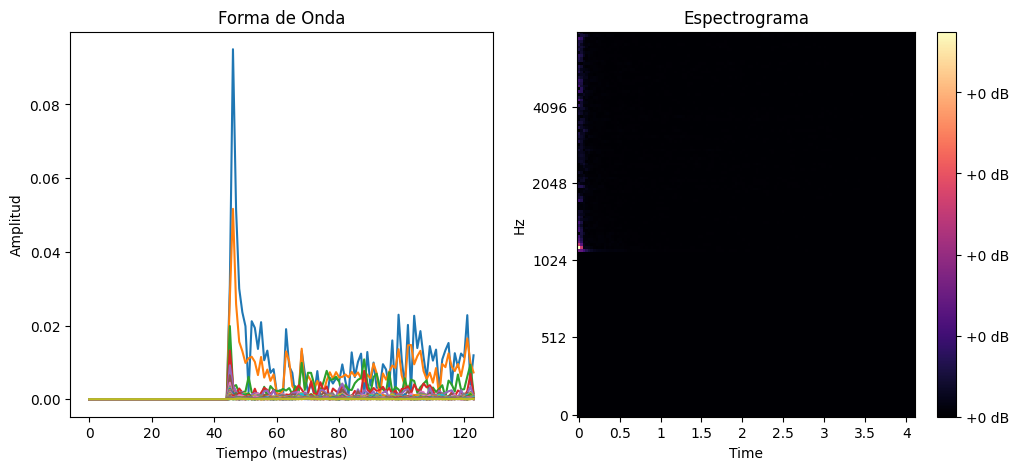

In [ ]:
# Obtener un batch del conjunto de validación
test_batch = next(iter(val_spectrogram_ds))

# Separar espectrogramas y etiquetas reales
spectrograms, true_labels = test_batch

# Realizar predicciones
predictions = cnn_model.predict(spectrograms)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Mostrar resultados para algunos ejemplos del batch
for i in range(4):  # Mostrar los primeros 5 ejemplos
    print(f"Ejemplo {i + 1}:")
    print(f"Etiqueta real: {label_names[true_labels[i].numpy()]}")
    print(f"Predicción: {label_names[predicted_labels[i]]}")

    # Graficar forma de onda
    plt.figure(figsize=(12, 5))

    # Forma de onda
    plt.subplot(1, 2, 1)
    plt.plot(spectrograms[i].numpy().squeeze())
    plt.title("Forma de Onda")
    plt.xlabel("Tiempo (muestras)")
    plt.ylabel("Amplitud")

    # Espectrograma
    plt.subplot(1, 2, 2)
    log_spec = spectrograms[i].numpy().squeeze()
    librosa.display.specshow(log_spec, sr=16000, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Espectrograma")

    plt.show()


In [ ]:
for x, y in val_spectrogram_cnn_ds.take(1):
    print(f"Forma de x (entrada): {x.shape}")
    print(f"Forma de y (etiqueta): {y.shape}")


Forma de x (entrada): (64, 124, 129, 1, 1)
Forma de y (etiqueta): (64,)


**MODELO RECURRENTE (RNN)**

In [ ]:
# Construir el modelo RNN
rnn_model = models.Sequential([
    layers.Input(shape=(124, 129)),  # Forma de entrada sin canal extra
    layers.LSTM(64, return_sequences=True),  # Primera capa LSTM
    layers.LSTM(32),  # Segunda capa LSTM
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Capa totalmente conectada
    layers.Dropout(0.5),  # Regularización para evitar sobreajuste
    layers.Dense(len(label_names), activation='softmax')  # Capa de salida para clasificación
])

# Compilar el modelo
rnn_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Resumen del modelo
rnn_model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 124, 64)             │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,820 (261.02 KB)

 Trainable params: 66,820 (261.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Asegurarse de que el dataset no tiene canal extra
def remove_channel_dimension(ds):
    return ds.map(
        lambda spec, label: (tf.squeeze(spec, axis=-1), label),  # Quitar canal extra si está presente
        num_parallel_calls=tf.data.AUTOTUNE
    )

train_spectrogram_rnn_ds = remove_channel_dimension(train_spectrogram_ds)
val_spectrogram_rnn_ds = remove_channel_dimension(val_spectrogram_ds)


En este caso,se crea un dataset con espectogramas sin el canal extra,ya que el modelo RNN no necesita la dimensión de canal adicional.

In [ ]:
# Entrenar el modelo RNN
history_rnn = rnn_model.fit(
    train_spectrogram_rnn_ds,
    validation_data=val_spectrogram_rnn_ds,
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
)



Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.2847 - loss: 1.8777 - val_accuracy: 0.3625 - val_loss: 1.7871
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.3251 - loss: 1.7770 - val_accuracy: 0.3875 - val_loss: 1.6915
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.4050 - loss: 1.6752 - val_accuracy: 0.4125 - val_loss: 1.6140
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step - accuracy: 0.4268 - loss: 1.5890 - val_accuracy: 0.4688 - val_loss: 1.5222
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.4791 - loss: 1.5028 - val_accuracy: 0.4688 - val_loss: 1.3927
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.4772 - loss: 1.4008 - val_accuracy: 0.5125 - val_loss: 1.3531
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.5098 - loss: 1.3492 - val_accuracy: 0.4938 - val_loss: 1.2978
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.5408 - loss: 1.3015 - val_accuracy: 0.

In [ ]:
rnn_eval = rnn_model.evaluate(val_spectrogram_rnn_ds)
print(f"RNN Validation Loss: {rnn_eval[0]}, RNN Validation Accuracy: {rnn_eval[1]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5727 - loss: 0.9299
RNN Validation Loss: 0.9528646469116211, RNN Validation Accuracy: 0.574999988079071


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Ejemplo 1:
Etiqueta real: japones
Predicción RNN: japones


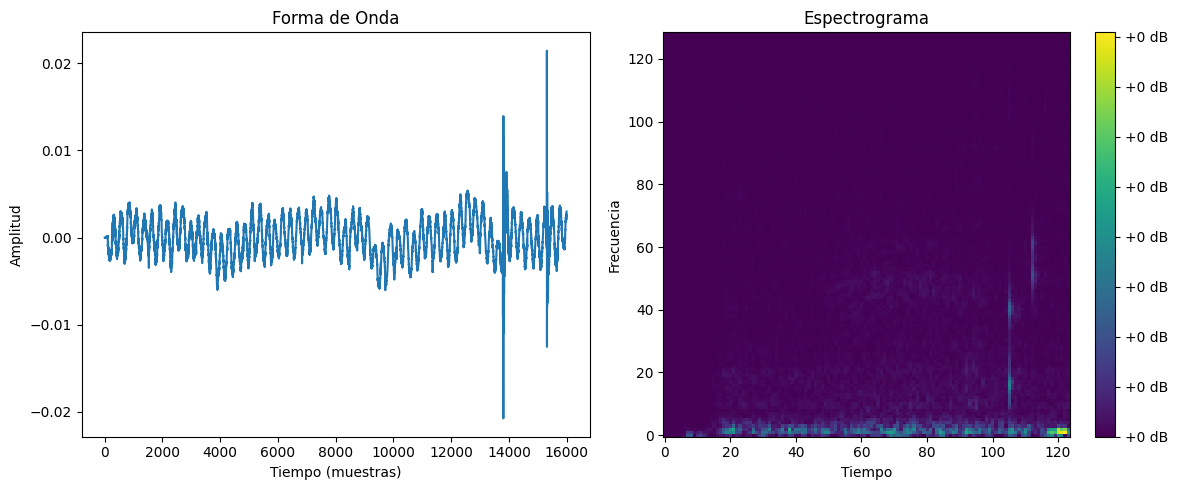

Ejemplo 2:
Etiqueta real: ingles
Predicción RNN: ingles


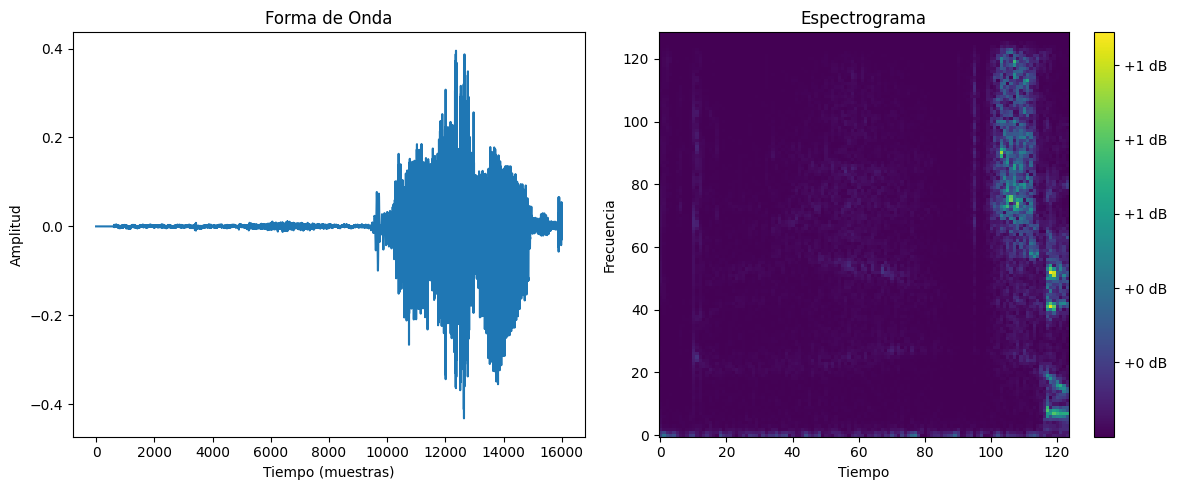

Ejemplo 3:
Etiqueta real: español
Predicción RNN: frances


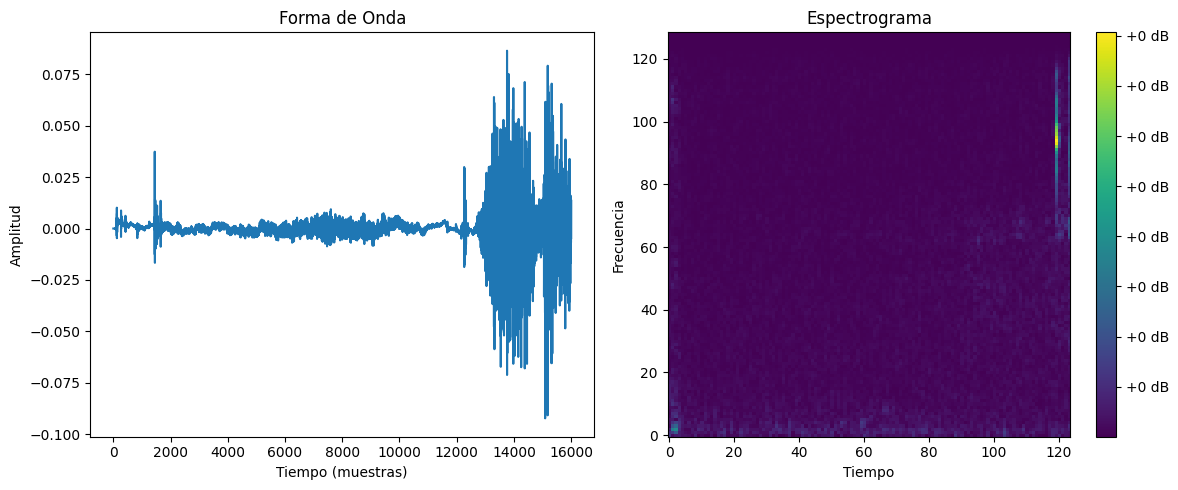

Ejemplo 4:
Etiqueta real: frances
Predicción RNN: frances


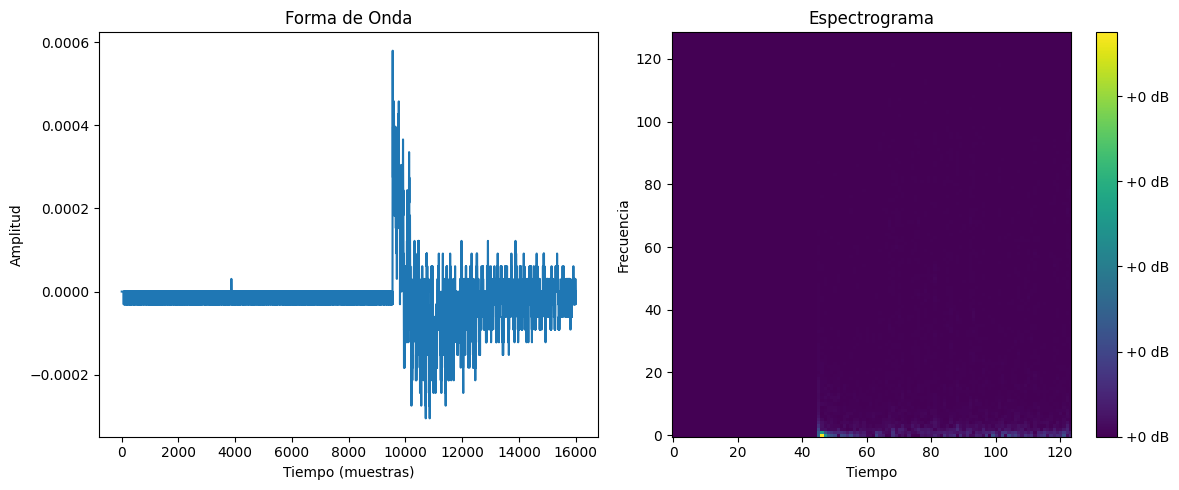

In [ ]:
# Crear un batch del conjunto de validación
test_batch_audio = next(iter(val_ds))  # Obtener el audio crudo
audio_waveforms, true_labels_waveforms = test_batch_audio

# Obtener espectrogramas y etiquetas reales
test_batch_spectrogram = next(iter(val_spectrogram_rnn_ds))
spectrograms, true_labels = test_batch_spectrogram

# Realizar predicciones con el modelo RNN
predictions = rnn_model.predict(spectrograms)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Mostrar resultados para algunos ejemplos
for i in range(4):  # Mostrar los primeros 5 ejemplos
    print(f"Ejemplo {i + 1}:")
    print(f"Etiqueta real: {label_names[true_labels[i].numpy()]}")
    print(f"Predicción RNN: {label_names[predicted_labels[i]]}")

    # Graficar forma de onda y espectrograma
    plt.figure(figsize=(12, 5))

    # Forma de onda
    plt.subplot(1, 2, 1)
    plt.plot(audio_waveforms[i].numpy())
    plt.title("Forma de Onda")
    plt.xlabel("Tiempo (muestras)")
    plt.ylabel("Amplitud")

    # Espectrograma
    plt.subplot(1, 2, 2)
    plt.imshow(spectrograms[i].numpy().T, aspect='auto', origin='lower', cmap='viridis')
    plt.title("Espectrograma")
    plt.xlabel("Tiempo")
    plt.ylabel("Frecuencia")
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()


**COMPARACION DE MODELOS**

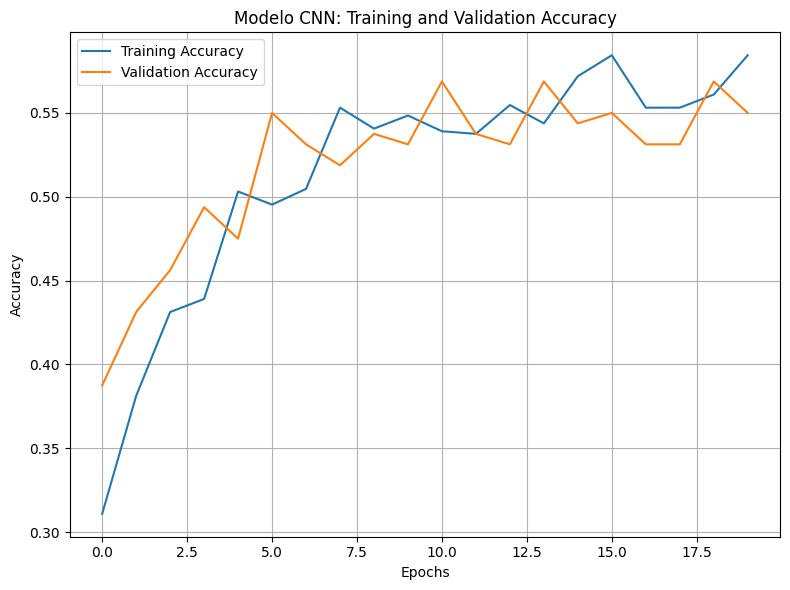

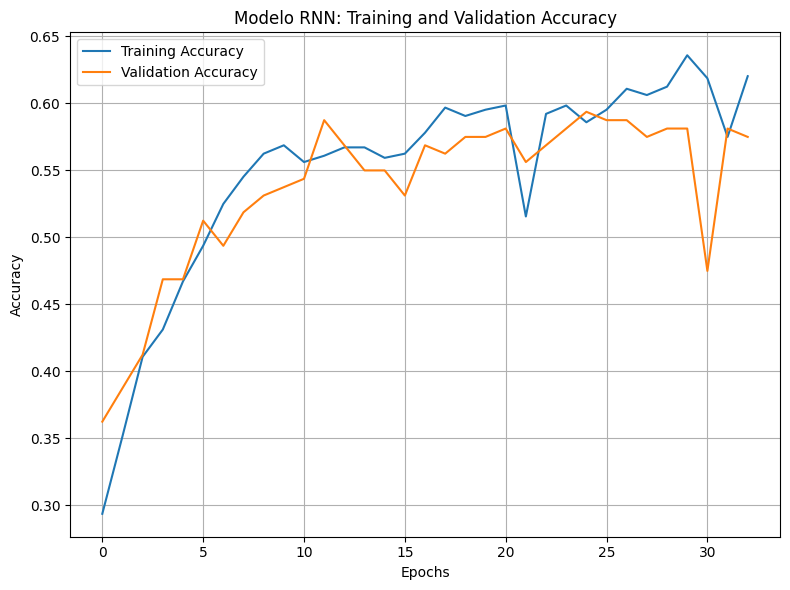

In [ ]:


# Función para graficar solo la precisión
def plot_accuracy(history, model_name):
    epochs = history.epoch
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(8, 6))

    # Precisión
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name}: Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Gráfica para el modelo CNN
plot_accuracy(cnn_history, 'Modelo CNN')

# Gráfica para el modelo RNN
plot_accuracy(history_rnn, 'Modelo RNN')


**CONCLUSION**

1. Modelo CNN

La curva de training accuracy es consistente y mejora hasta estabilizarse en torno al 0.55.
La curva de validation accuracy  mejora inicialmente, pero se estabiliza y fluctúa ligeramente, manteniéndose cercana a la de entrenamiento.
Conclusión:
El modelo generaliza moderadamente bien, ya que las curvas de entrenamiento y validación están cerca. Sin embargo, hay margen de mejora en la precisión general.
No hay señales fuertes de sobreajuste, pero la validación muestra que la capacidad del modelo podría ser limitada.

2. Modelo RNN

Las curvas de training accuracy y validation accuracy están muy próximas y fluctúan más que en el modelo CNN.
La precisión de validación alcanza niveles similares al de entrenamiento, pero presenta caídas esporádicas (posible sensibilidad al ruido).
Conclusión:

El modelo generaliza mejor que el CNN, con precisión de validación más alineada con la de entrenamiento.
Las fluctuaciones indican que el modelo puede ser inestable y susceptible al ruido, lo que podría mejorarse con ajustes adicionales.

En ambos modelos el comportamiento es bastante erratico,lo que sugiere que le cuesta encontrar patrones consistentes en los datos. Se puede observar que a ambos modelos les cuesta predecir el idioma español,y lo confunden con frances.